# Implementing transfer learning on Vgg16 using pyTorch

Hi! I am  [Jean-Nicolas Jérémie](https://laurentperrinet.github.io/author/jean-nicolas-jeremie/) and the goal of this notebook is to provide a framework to implement (and experiment with) [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning) on deep convolutional neuronal network (DCNN). In a nutshell, [transfer learning](https://www.analyticsvidhya.com/blog/2021/06/transfer-learning-using-vgg16-in-pytorch/) allows to re-use the knowlegde learned on a problem, such as categorizing images from  a large dataset, and apply it to a different (yet related) problem, performing the categorization on a smaller dataset. It is a powerful method as it allows to implement complex task *de novo* quite rapidly (in a few hours) without having to retrain the millions of parameters of a DCNN (which takes days of computations). The basic hypothesis is that it suffices to [re-train the last classification layers](https://www.kaggle.com/carloalbertobarbano/vgg16-transfer-learning-pytorch) (the head) while keeping the first layers fixed. Here, these networks teach us also some interesting insights into how living systems may perform such categorization tasks.

Based on our [previous work]( https://laurentperrinet.github.io/sciblog/posts/2020-09-28-benchmarking-cnns.html), we will start from a [VGG16 network](https://pytorch.org/hub/pytorch_vision_vgg/) loaded from the [`torchvision.models` library](https://github.com/pytorch/vision/blob/main/torchvision/models/vgg.py) and pre-trained on the [Imagenet](http://image-net.org/) dataset wich allows to perform label detection on naturals images for $K = 1000$ labels. Our goal here will be to re-train the last fully-Connected layer of the network to perfom the same task but in a sub-set of $K = 10$ labels from the Imagenet dataset. 

Moreover, we are going to evaluate different strategies of transfer learning:

* VGG General : Substitute the last layer of the pyTorch VGG16 network ($K = 1000$ labels) with a new layer build from a specific subset ($K = 10$ labels).
* VGG Linear : Add a new layer build from a specific subset ($K = 10$ labels) after the last Fully-Connected layer of the the pyTorch VGG16 network.
* VGG Gray : Same architecture as the VGG General network but trained with grayscale images.
* VGG Scale : Same architecture as the VGG General network but trained with images of different size.

In this notebook, I will use the [pyTorch](https://pytorch.org/) library for running the networks and the [pandas](https://pandas.pydata.org/docs/getting_started/index.html) library to collect and display the results. This notebook was done during a master 2 internship at the Neurosciences Institute of Timone (INT) under the supervision of [Laurent PERRINET](https://laurentperrinet.github.io/). It is curated in the following [github repo](https://github.com/JNJER/2020-06-26_fast_and_curious.git).

<!-- TEASER_END -->

In our [previous work]( https://laurentperrinet.github.io/sciblog/posts/2020-09-28-benchmarking-cnns.html), as the VGG16 network was first trained on the entire dataset of $K=1000$ labels, and in order to recover the classification confidence predicted by the model according to the specific subset of classes ($K = 10$ labels) on which it is tested, the output `softmax` mathematical function of the last layer of the network was slightly changed. By assuming that we know *a priori* that the image belongs to one (and only one) category from the sub-set the probabilities obtained would correspond to a confidence of classification discriminating only the classes of interest and can be compared to a chance level of $1 /K$. This creates another network (which is not retrained) directly based on VGG:

* VGG Subset : Just consider the specific subset ($K = 10$ labels) from the last layer of the pyTorch VGG16 network ($K = 1000$ labels).

This notebook aims in addition to test this hypothesis. Our use case consists of measuring whether there are differences in the likelihood of these networks during an image recognition task on a sub-set of $1000$ classes of the `ImageNet` library, with $K = 10$ (experiment 1). Additionally, we will implement some image transformations as up/down-sampling (experiment 2) or transforming to grayscale (experiment 3) to quantify their influence on the accuracy and computation time of each network.


*Some useful links :*

* https://jaketae.github.io/study/pytorch-vgg/
* https://www.kaggle.com/carloalbertobarbano/vgg16-transfer-learning-pytorch
* https://www.kaggle.com/paultimothymooney/detect-retina-damage-from-oct-images/notebook

* https://en.wikipedia.org/wiki/Transfer_learning
* https://github.com/laurentperrinet/ImageNet-Datasets-Downloader/tree/8d1c0925b5512f48978177a76e7b851ff40acb7b

Let's first install requirements

In [ ]:
%pip install --upgrade -r requirements.txt

In [ ]:
%matplotlib inline
# uncommment to re-run training
#%rm -fr models
%mkdir -p DCNN_transfer_learning
%mkdir -p results
%mkdir -p models

## Initialization of the libraries/variables

Our coding strategy is to build up a small library as a package of scripts in the `DCNN_benchmark` folder and to run all calls to that library from this notebook. This follows our [previous work]( https://laurentperrinet.github.io/sciblog/posts/2020-09-28-benchmarking-cnns.html) in which we benchmarked various DCNNs and which allowed us to select VGG16 as a good compromise between performance and complexity.

First of all, a `init.py` script defines all our usefull variables like the new labels to learn, the number of training images or the root folder to use. Also, we import libraries to train the different networks and display the results.

In [ ]:
scriptname = 'DCNN_transfer_learning/init.py'

In [11]:
%%writefile {scriptname}

# Importing libraries
import torch
import argparse
import imageio
import json
import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
import numpy as np
#from numpy import random
import os
import requests
import time

from time import strftime, gmtime
datetag = strftime("%Y-%m-%d", gmtime())
datetag = '2021-10-21'

HOST, device = os.uname()[1], torch.device("cuda" if torch.cuda.is_available() else "cpu")
HOST, device = 'inv-ope-de06', torch.device("cuda")

    
# to store results
import pandas as pd

def arg_parse():
    DEBUG = 25
    DEBUG = 1
    parser = argparse.ArgumentParser(description='DCNN_transfer_learning/init.py set root')
    parser.add_argument("--root", dest = 'root', help = "Directory containing images to perform the training",
                        default = 'data', type = str)
    parser.add_argument("--folders", dest = 'folders', help =  "Set the training, validation and testing folders relative to the root",
                        default = ['test', 'val', 'train'], type = list)
    parser.add_argument("--N_images", dest = 'N_images', help ="Set the number of images per classe in the train folder",
                        default = [400//DEBUG, 200//DEBUG, 1000//DEBUG], type = list)
    parser.add_argument("--HOST", dest = 'HOST', help = "Set the name of your machine",
                    default=HOST, type = str)
    parser.add_argument("--datetag", dest = 'datetag', help = "Set the datetag of the result's file",
                    default = datetag, type = str)
    parser.add_argument("--image_size", dest = 'image_size', help = "Set the default image_size of the input",
                    default = 256)
    parser.add_argument("--image_sizes", dest = 'image_sizes', help = "Set the image_sizes of the input for experiment 2 (downscaling)",
                    default = [64, 128, 256, 512], type = list)
    parser.add_argument("--num_epochs", dest = 'num_epochs', help = "Set the number of epoch to perform during the traitransportationning phase",
                    default = 200//DEBUG)
    parser.add_argument("--batch_size", dest = 'batch_size', help="Set the batch size", default = 16)
    parser.add_argument("--lr", dest = 'lr', help="Set the learning rate", default = 0.001)
    parser.add_argument("--momentum", dest = 'momentum', help="Set the momentum", default = 0.9)
    parser.add_argument("--subset_i_labels", dest = 'subset_i_labels', help="Set the labels of the classes (list of int)",
                    default = [945, 513, 886, 508, 786, 310, 373, 145, 146, 396], type = list)
    parser.add_argument("--class_loader", dest = 'class_loader', help = "Set the Directory containing imagenet downloaders class",
                        default = 'imagenet_label_to_wordnet_synset.json', type = str)
    parser.add_argument("--url_loader", dest = 'url_loader', help = "Set the file containing imagenet urls",
                        default = 'Imagenet_urls_ILSVRC_2016.json', type = str)
    parser.add_argument("--model_path", dest = 'model_path', help = "Set the path to the pre-trained model",
                        default = 'models/re-trained_', type = str)
    parser.add_argument("--model_names", dest = 'model_names', help = "Modes for the new trained networks",
                        default = ['vgg16_lin', 'vgg16_gen', 'vgg16_scale', 'vgg16_gray', ], type = list)
    return parser.parse_args()

args = arg_parse()
datetag = args.datetag
json_fname = os.path.join('results', datetag + '_config_args.json')
load_parse = False # False to custom the config

if load_parse:
    with open(json_fname, 'rt') as f:
        print(f'file {json_fname} exists: LOADING')
        override = json.load(f)
        args.__dict__.update(override)
else:
    print(f'Creating file {json_fname}')
    with open(json_fname, 'wt') as f:
        json.dump(vars(args), f, indent=4)
    
# matplotlib parameters
colors = ['b', 'r', 'k', 'g', 'm']
fig_width = 20
phi = (np.sqrt(5)+1)/2 # golden ratio for the figures :-)

#to plot & display 
def pprint(message): #display function
    print('-'*len(message))
    print(message)
    print('-'*len(message))
    
#DCCN training
print('On date', args.datetag, ', Running benchmark on host', args.HOST, ' with device', device.type)

# Labels Configuration
N_labels = len(args.subset_i_labels)
id_dl = []

paths = {}
N_images_per_class = {}
for folder, N_image in zip(args.folders, args.N_images):
    paths[folder] = os.path.join(args.root, folder) # data path
    N_images_per_class[folder] = N_image
    os.makedirs(paths[folder], exist_ok=True)
    
with open(args.class_loader, 'r') as fp: # get all the classes on the data_downloader
    imagenet = json.load(fp)

# gathering labels
labels = []
reverse_id_labels = {}
for a, img_id in enumerate(imagenet):
    reverse_id_labels[str('n' + (imagenet[img_id]['id'].replace('-n','')))] = imagenet[img_id]['label'].split(',')[0]
    labels.append(imagenet[img_id]['label'].split(',')[0])
    if int(img_id) in args.subset_i_labels:
        id_dl.append('n' + (imagenet[img_id]['id'].replace('-n','')))    
        
# a reverse look-up-table giving the index of a given label (within the whole set of imagenet labels)
reverse_labels = {}
for i_label, label in enumerate(labels):
    reverse_labels[label] = i_label
# a reverse look-up-table giving the index of a given i_label (within the sub-set of classes)
reverse_subset_i_labels = {}
for i_label, label in enumerate(args.subset_i_labels):
    reverse_subset_i_labels[label] = i_label
    
# a reverse look-up-table giving the label of a given index in the last layer of the new model (within the sub-set of classes)
subset_labels = []
pprint('List of Pre-selected classes : ')
# choosing the selected classes for recognition
for i_label, id_ in zip(args.subset_i_labels, id_dl) : 
    subset_labels.append(labels[i_label])
    print('-> label', i_label, '=', labels[i_label], '\nid wordnet : ', id_)
subset_labels.sort()

Overwriting experiment_train.py


In [12]:
%run -int {scriptname} 

Creating file results/2021-10-21_config_args.json
On date 2021-10-21 , Running benchmark on host inv-ope-de06  with device cuda
-------------------------------
List of Pre-selected classes : 
-------------------------------
-> label 945 = bell pepper 
id wordnet :  n02056570
-> label 513 = cornet 
id wordnet :  n02058221
-> label 886 = vending machine 
id wordnet :  n02219486
-> label 508 = computer keyboard 
id wordnet :  n02487347
-> label 786 = sewing machine 
id wordnet :  n02643566
-> label 310 = ant 
id wordnet :  n03085013
-> label 373 = macaque 
id wordnet :  n03110669
-> label 145 = king penguin 
id wordnet :  n04179913
-> label 146 = albatross 
id wordnet :  n04525305
-> label 396 = lionfish 
id wordnet :  n07720875

IPython CPU timings (estimated):
  User   :       0.01 s.
  System :       0.01 s.
Wall time:       0.02 s.


## Download the `train` & `val` dataset

In the `dataset.py`, we use an archive of the Imagenet fall 2011 urls to populate datasets based on the pre-selected classes listed in the `DCNN_benchmark/init.py` file. The following script is inspired by [previous work](https://github.com/laurentperrinet/ImageNet-Datasets-Downloader/) in our group.

In [ ]:
scriptname = 'DCNN_transfer_learning/dataset.py'

In [ ]:
%%writefile {scriptname}

from DCNN_transfer_learning.init import *  

from requests.exceptions import ConnectionError, ReadTimeout, TooManyRedirects, MissingSchema, InvalidURL

verbose = False 

with open(args.url_loader) as json_file:
    Imagenet_urls_ILSVRC_2016 = json.load(json_file)

def clean_list(list_dir, patterns=['.DS_Store']):
    for pattern in patterns:
        if pattern in list_dir: list_dir.remove('.DS_Store')
    return list_dir
    
def get_image(img_url, class_folder, timeout=3.):
    if verbose:
        print(f'Processing {img_url}')

    img_name = img_url.split('/')[-1]
    # handle strange file names
    img_name = img_name.split("?")[0]
    if ('jpe' in img_name) or ('gif' in img_name)  or (len(img_name) <= 1):
        if verbose :
            print('Bad format for the image')
    else:
        try:
            img_resp = requests.get(img_url, timeout=timeout)
            if not 'content-type' in img_resp.headers :
                if verbose : print('No content-type')
            elif not 'image' in img_resp.headers['content-type'] :
                        if verbose : print('Not an image')
            elif (len(img_resp.content) < 5000) :
                if verbose : print('Content to short')
            else:
                # LuP some files miss the extension?
                if not 'jpg' in img_name : img_name += 'jpg'

                img_file_path = os.path.join(class_folder, img_name)
                if verbose : print('Good URl, now saving...')
                with open(img_file_path, 'wb') as img_f:
                    img_f.write(img_resp.content)
                    list_dir = os.listdir(class_folder)
                return True

        except Exception as e:
            if verbose : print(f"Failed with {e} for url {img_url}")
    return False

if not os.path.isdir(args.root):
    print(f'folder {args.root} did not exist! creating folder..')
    os.makedirs(args.root, exist_ok=True)

iter_ = 0    
for folder in args.folders :
    filename = f'results/{datetag}_dataset_{folder}_{args.HOST}.json'
    os.makedirs(paths[folder], exist_ok=True)
    list_dir = clean_list(os.listdir(paths[folder]))
        
    # if the folder is empty, download the images using the ImageNet-Datasets-Downloader
    if len(list_dir) < N_labels: 
        df_dataset = pd.DataFrame([], columns=['is_flickr', 'dt', 'lab_work', 'class_wnid', 'class_name'])
        tentativ_ = 0
        print(f'The {folder} folder does not have anough classes, downloading some more \n') 
        for class_wnid in id_dl:
            class_name = reverse_id_labels[class_wnid]
            print(f'Scraping images for class \"{class_name}\"')
            class_folder = os.path.join(paths[folder], class_name)
            os.makedirs(class_folder, exist_ok=True)                      
            list_dir = os.listdir(class_folder)
            #for i, j in enumerate(Imagenet_urls_ILSVRC_2016[str(class_wnid)]):
            for i in range(iter_, len(Imagenet_urls_ILSVRC_2016[str(class_wnid)]), 1):
                if len(list_dir) < N_images_per_class[folder] :
                    tentativ_ +=1
                    try :
                        resp = Imagenet_urls_ILSVRC_2016[str(class_wnid)][i]
                    except : 
                        break
                    tic = time.time()
                    worked = get_image(resp, class_folder)
                    if not worked:
                        if verbose :
                            print(Imagenet_urls_ILSVRC_2016[str(class_wnid)].pop(i), ' does not work, deleting the url of the database')
                        else :
                            del(Imagenet_urls_ILSVRC_2016[str(class_wnid)][i])

                    dt = time.time() - tic
                    if verbose: 
                        print('is_flickr :', is_flickr,'dt :', dt,'worked :', worked, 'class_wnid : ', class_wnid, 'class_name :', class_name)
                    df_dataset.loc[tentativ_] = {'is_flickr':1 if 'flickr' in resp else 0,'dt':dt,'lab_work':worked, 'class_wnid':class_wnid, 'class_name':class_name}
                    list_dir = os.listdir(class_folder)
                    print(f'\r{len(list_dir)} / {N_images_per_class[folder]}', end='', flush=True)
                else:
                    print(f'\r{len(list_dir)} / {N_images_per_class[folder]}', end='', flush=True)
                    break
            print('\n')
            if len(list_dir) < N_images_per_class[folder] :
                print('Not anough working url to complete the dataset') 
        list_dir = os.listdir(paths[folder])
        if True :
            df_dataset.to_json(filename)


    elif len(os.listdir(paths[folder])) == N_labels :
        pprint(f'The folder already contains : {len(list_dir)} classes')
        
    iter_ += N_images_per_class[folder]
    
if False: 
    # replace the file with that URLs that worked - removes the ones that failed
    print(f'Replacing file {args.url_loader}')
    with open(args.url_loader, 'wt') as f:
        json.dump(Imagenet_urls_ILSVRC_2016, f, indent=4)


In [ ]:
%run -int {scriptname}

Let's plot some statistics for the scrapped images:

In [ ]:
for folder in args.folders : 
    filename = f'results/{datetag}_dataset_{folder}_{args.HOST}.json'
    if os.path.isfile(filename):
        df_dataset = pd.read_json(filename)

        df_type = pd.DataFrame({'urls_type': [len(df_dataset[df_dataset['is_flickr']==1]), 
                                              len(df_dataset[df_dataset['is_flickr']==0])]},
                          index=['is_flickr', 'not_flikr'])
        df_flikr = pd.DataFrame({'not_flikr': [df_dataset[df_dataset['is_flickr']==0]['lab_work'].sum(), 
                                               (len(df_dataset[df_dataset['is_flickr']==0]) - df_dataset[df_dataset['is_flickr']==0]['lab_work'].sum())],
                                 'is_flickr': [df_dataset[df_dataset['is_flickr']==1]['lab_work'].sum(), 
                                               (len(df_dataset[df_dataset['is_flickr']==1]) - df_dataset[df_dataset['is_flickr']==1]['lab_work'].sum())]},
                                  index=['worked', 'not_working'])
        df_all = pd.DataFrame({'url': [len(df_dataset[df_dataset['lab_work']==1]), len(df_dataset[df_dataset['lab_work']==0])]},
                          index=['worked', 'not_working'])

        plot_type = df_type.plot.pie(y='urls_type', figsize=(5, 5), labeldistance=None)
        plot_type.set_title('Stats for the folder '+ folder + ' (' + str(len(df_dataset)) + ' attempts) :', size = 18)
        if not len(df_dataset[df_dataset['is_flickr']==0]) == 0 or len(df_dataset[df_dataset['is_flickr']==1]) == 0: 
            plot_flickr = df_flikr.plot.pie(subplots=True, figsize=(11, 6), labeldistance=None)
        plot_all = df_all.plot.pie(y='url', figsize=(5, 5), labeldistance=None)
    else:
        print(f'The file {filename} is not available...')

TODO : show one representative image from each class

## Transfer learning and dataset config

In the `model.py` scrip,t we first define the `transform` functions for the datasets. To perform image augmentation, we apply the pyTorch `AutoAugment` function to the `train` and `val` dataset. Then, we load the pretrained models and store them in memory.

In [ ]:
scriptname = 'DCNN_transfer_learning/model.py'

In [ ]:
%%writefile {scriptname}

from DCNN_transfer_learning.init import *

import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder

# normalization used to train VGG
# see https://pytorch.org/hub/pytorch_vision_vgg/
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
transforms_norm = transforms.Normalize(mean=mean, std=std) # to normalize colors on the imagenet dataset

import seaborn as sns
import sklearn.metrics
from scipy import stats
from scipy.special import logit, expit

# VGG-16 datasets initialisation
def datasets_transforms(image_size=args.image_size, p=0, num_workers=1, batch_size=args.batch_size):
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((int(image_size), int(image_size))),
            transforms.AutoAugment(), # https://pytorch.org/vision/master/transforms.html#torchvision.transforms.AutoAugment
            transforms.RandomGrayscale(p=p),
            transforms.ToTensor(),      # Convert the image to pyTorch Tensor data type.
            transforms_norm ]),

        'val': transforms.Compose([
            transforms.Resize((int(image_size), int(image_size))),
            transforms.AutoAugment(), # https://pytorch.org/vision/master/transforms.html#torchvision.transforms.AutoAugment
            transforms.RandomGrayscale(p=p),
            transforms.ToTensor(),      # Convert the image to pyTorch Tensor data type.
            transforms_norm ]),

        'test': transforms.Compose([
            transforms.Resize((int(image_size), int(image_size))),
            transforms.RandomGrayscale(p=p),
            transforms.ToTensor(),      # Convert the image to pyTorch Tensor data type.
            transforms_norm ]),
    }
    #print(paths)
    

    image_datasets = {
        folder: datasets.ImageFolder(
            paths[folder], 
            transform=data_transforms[folder]
        )
        for folder in args.folders
    }

    dataloaders = {
        folder: torch.utils.data.DataLoader(
            image_datasets[folder], batch_size=batch_size,
            shuffle=True, num_workers=num_workers
        )
        for folder in args.folders
    }

    dataset_sizes = {folder: len(image_datasets[folder]) for folder in args.folders}

    return dataset_sizes, dataloaders, image_datasets, data_transforms

(dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(image_size=args.image_size)

for folder in args.folders : print(f"Loaded {dataset_sizes[folder]} images under {folder}")
class_names = image_datasets['train'].classes
print("Classes: ", image_datasets['train'].classes)
n_output = len(os.listdir(paths['train']))

In [ ]:
%run -int {scriptname}

## Training process

Finaly, we implement the training process in `experiment_train.py`, using a classic training script with pyTorch. For further statistical analyses, we extract factors (like the accuracy and loss) within a `pandas` object (a `DataFrame`). 

In [1]:
scriptname = 'experiment_train.py'

In [2]:
# TODO : compare with full learning

In [3]:
%%writefile {scriptname}
from DCNN_transfer_learning.model import *
import torch.nn as nn

def train_model(model, num_epochs, dataloaders, lr=args.lr, momentum=args.momentum, log_interval=100):
    
    model.to(device)
    if momentum == 0.: # TODO : try Adam?
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)#, betas=(beta1, beta2), amsgrad=amsgrad)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum) # to set training variables

    df_train = pd.DataFrame([], columns=['epoch', 'avg_loss', 'avg_acc', 'avg_loss_val', 'avg_acc_val', 'device_type']) 

    for epoch in range(num_epochs):
        loss_train = 0
        acc_train = 0
        for i, (images, labels) in enumerate(dataloaders['train']):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            loss_train += loss.item() * images.size(0)
            _, preds = torch.max(outputs.data, 1)
            acc_train += torch.sum(preds == labels.data)
            
        avg_loss = loss_train / dataset_sizes['train']
        avg_acc = acc_train / dataset_sizes['train']
           
        with torch.no_grad():
            loss_val = 0
            acc_val = 0
            for i, (images, labels) in enumerate(dataloaders['val']):
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                loss_val += loss.item() * images.size(0)
                _, preds = torch.max(outputs.data, 1)
                acc_val += torch.sum(preds == labels.data)
        
            avg_loss_val = loss_val / dataset_sizes['val']
            avg_acc_val = acc_val / dataset_sizes['val']
        
        df_train.loc[epoch] = {'epoch':epoch, 'avg_loss':avg_loss, 'avg_acc':float(avg_acc),
                               'avg_loss_val':avg_loss_val, 'avg_acc_val':float(avg_acc_val), 'device_type':device.type}
        print(f"Epoch {epoch+1}/{num_epochs} : train= loss: {avg_loss:.4f} / acc : {avg_acc:.4f} - val= loss : {avg_loss_val:.4f} / acc : {avg_acc_val:.4f}")

    model.cpu()
    torch.cuda.empty_cache()
    return model, df_train

 
criterion = nn.CrossEntropyLoss()

def main():

  # Training and saving the network

  models_vgg = {}
  opt = {}
  #df_train = {}

  models_vgg['vgg'] = torchvision.models.vgg16(pretrained=True)

  # Downloading the model
  model_filenames = {}
  for model_name in args.model_names:
      model_filenames[model_name] = args.model_path + model_name + '.pt'
      filename = f'results/{datetag}_{args.HOST}_train_{model_name}.json'

      models_vgg[model_name] = torchvision.models.vgg16(pretrained=True)
      # Freeze training for all layers
      # Newly created modules have require_grad=True by default
      for param in models_vgg[model_name].features.parameters():
          param.require_grad = False 

      if model_name == 'vgg16_lin':
          num_features = models_vgg[model_name].classifier[-1].out_features
          features = list(models_vgg[model_name].classifier.children())
          features.extend([nn.Linear(num_features, n_output)]) # Adding one layer on top of last layer
          models_vgg[model_name].classifier = nn.Sequential(*features)

      else : 
          num_features = models_vgg[model_name].classifier[-1].in_features
          features = list(models_vgg[model_name].classifier.children())[:-1] # Remove last layer
          features.extend([nn.Linear(num_features, n_output)]) # Add our layer with 10 outputs
          models_vgg[model_name].classifier = nn.Sequential(*features) # Replace the model classifier

      if os.path.isfile(model_filenames[model_name]):
          print("Loading pretrained model for..", model_name, ' from', model_filenames[model_name])
          #print("Resume_training : ", resume_training)

          if device.type == 'cuda':
              models_vgg[model_name].load_state_dict(torch.load(model_filenames[model_name])) #on GPU
          else:
              models_vgg[model_name].load_state_dict(torch.load(model_filenames[model_name], map_location=torch.device('cpu'))) #on CPU

      else:
          print("Re-training pretrained model...", model_filenames[model_name])
          since = time.time()

          p = 1 if model_name == 'vgg16_gray' else 0
          if model_name =='vgg16_scale':
              df_train = None
              for image_size_ in args.image_sizes: # starting with low resolution images 
                  print(f"Traning {model_name}, image_size = {image_size_}, p (Grayscale) = {p}")
                  (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(image_size=image_size_, p=p)
                  models_vgg[model_name], df_train_ = train_model(models_vgg[model_name], num_epochs=args.num_epochs//len(args.image_sizes),
                                                                 dataloaders=dataloaders)
                  df_train = df_train_ if df_train is None else df_train.append(df_train_, ignore_index=True)
          else :
              print(f"Traning {model_name}, image_size = {args.image_size}, p (Grayscale) = {p}")
              (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(image_size=args.image_size, p=p)
              models_vgg[model_name], df_train = train_model(models_vgg[model_name], num_epochs=args.num_epochs,
                                                            dataloaders=dataloaders)
          torch.save(models_vgg[model_name].state_dict(), model_filenames[model_name])
          df_train.to_json(filename)
          elapsed_time = time.time() - since
          print(f"Training completed in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")
          print()

main()

Overwriting experiment_train.py


In [4]:
%run -int {scriptname}

Creating file results/2021-10-21_config_args.json
On date 2021-10-21 , Running benchmark on host ekla  with device cpu
-------------------------------
List of Pre-selected classes : 
-------------------------------
-> label 945 = bell pepper 
id wordnet :  n02056570
-> label 513 = cornet 
id wordnet :  n02058221
-> label 886 = vending machine 
id wordnet :  n02219486
-> label 508 = computer keyboard 
id wordnet :  n02487347
-> label 786 = sewing machine 
id wordnet :  n02643566
-> label 310 = ant 
id wordnet :  n03085013
-> label 373 = macaque 
id wordnet :  n03110669
-> label 145 = king penguin 
id wordnet :  n04179913
-> label 146 = albatross 
id wordnet :  n04525305
-> label 396 = lionfish 
id wordnet :  n07720875
Loaded 3921 images under test
Loaded 1981 images under val
Loaded 5228 images under train
Classes:  ['albatross', 'ant', 'bell pepper', 'computer keyboard', 'cornet', 'king penguin', 'lionfish', 'macaque', 'sewing machine', 'vending machine']
Loading pretrained model for..

Here we display both average accuracy and loss during the training phase and during the validation one : 

In [13]:
model_name = 'vgg16_lin'
filename = f'results/{datetag}_{args.HOST}_train_{model_name}.json'
%ls {filename}

results/2021-10-21_inv-ope-de06_train_vgg16_lin.json


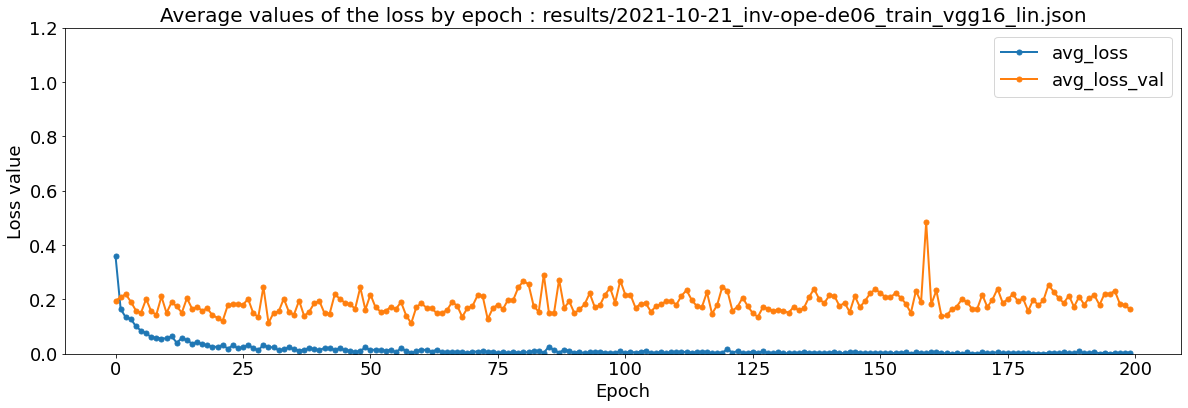

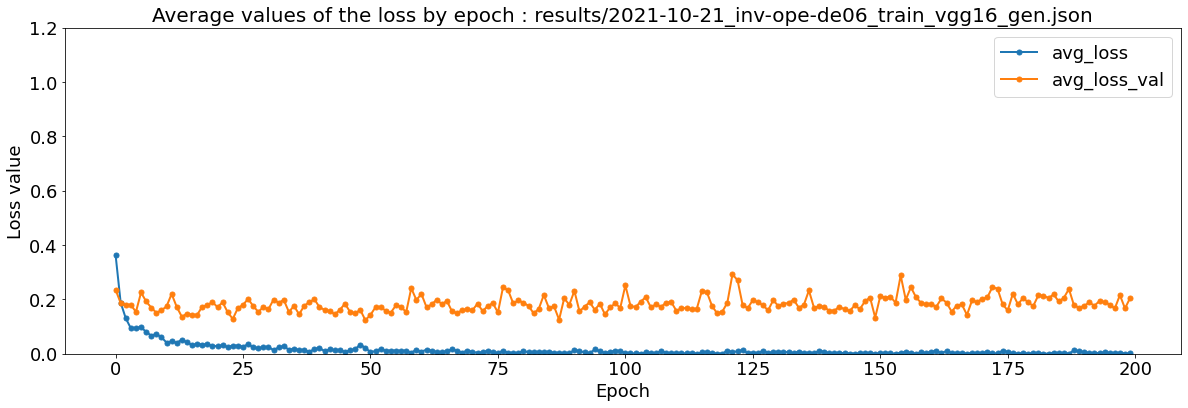

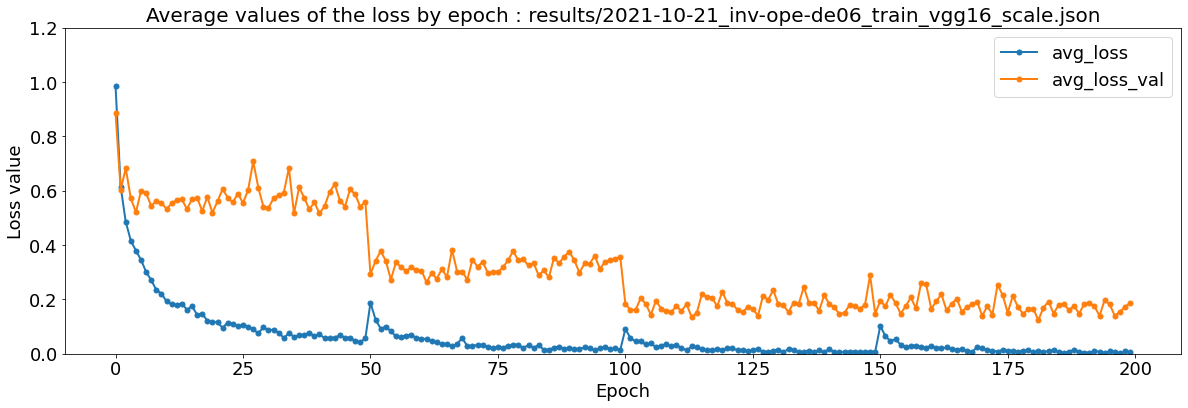

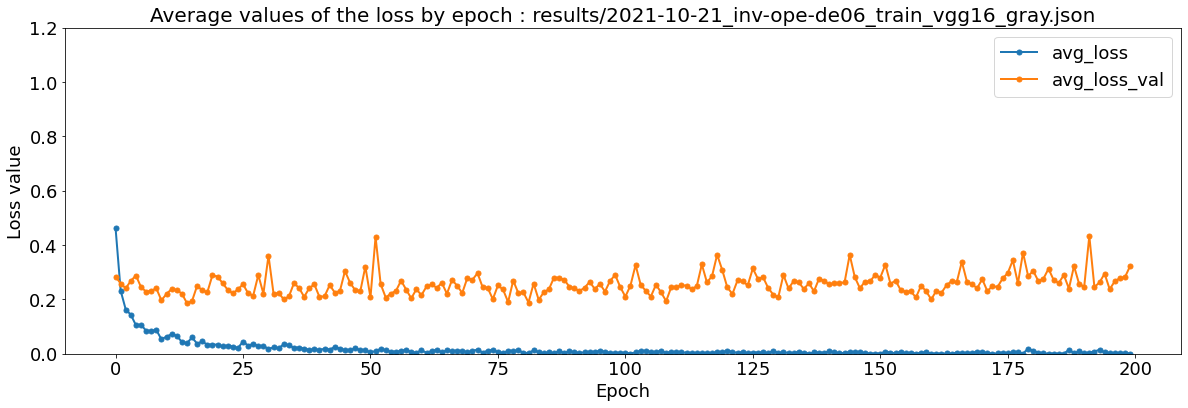

In [14]:
for model_name in args.model_names:
    filename = f'results/{datetag}_{args.HOST}_train_{model_name}.json'
    df_train = pd.read_json(filename)
    fig, axs = plt.subplots(figsize=(fig_width, fig_width/phi//2))
    # plt.xticks(fontsize=18)
    # plt.yticks(fontsize=18)
    ax = df_train['avg_loss'].plot(lw=2, marker='.', markersize=10)
    ax = df_train['avg_loss_val'].plot(lw=2, marker='.', markersize=10)
    ax.legend(["avg_loss", "avg_loss_val"], fontsize=18);
    ax.set_xlabel("Epoch", size=18)
    ax.set_ylabel("Loss value", size=18)
    ax.set_ylim(0, 1.2)
    axs.set_title(f'Average values of the loss by epoch : {filename}' , size = 20)

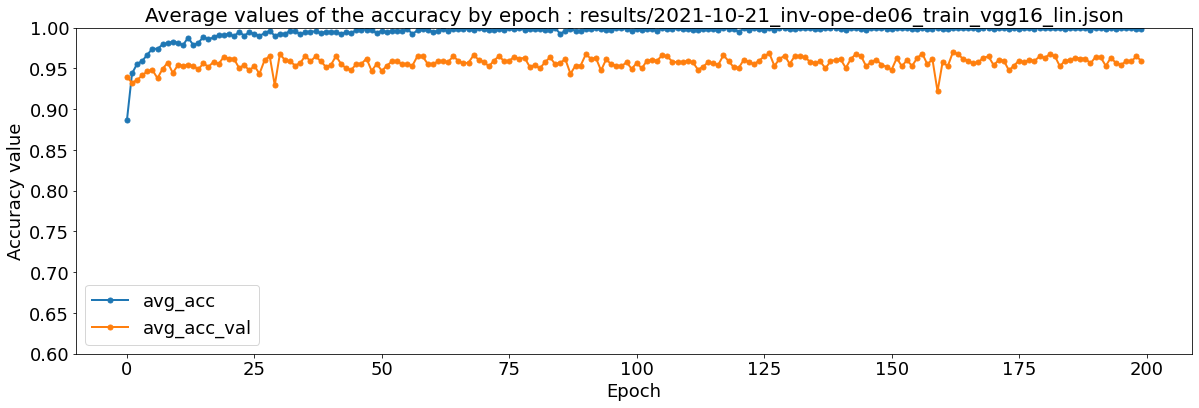

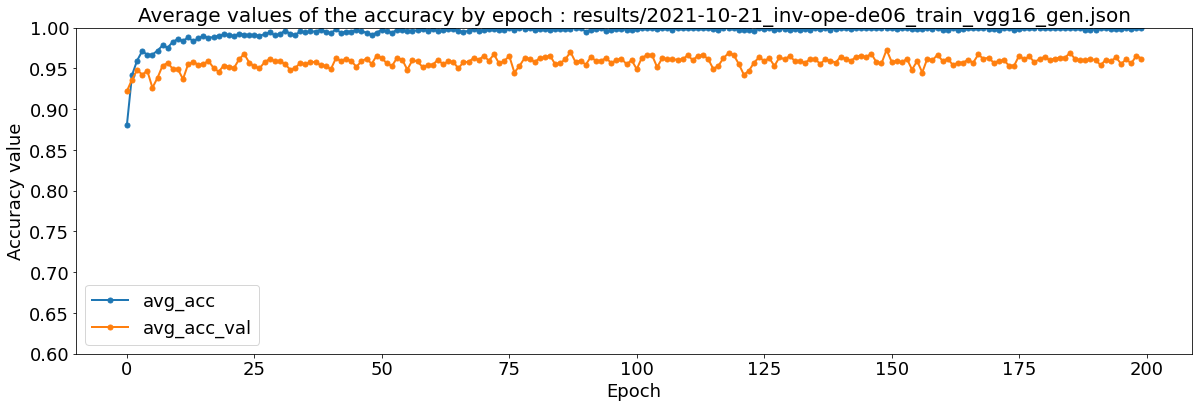

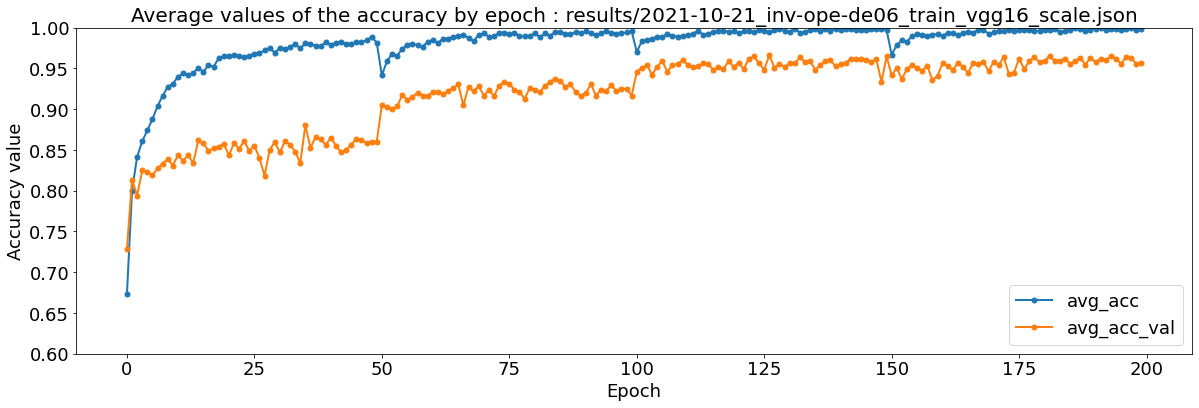

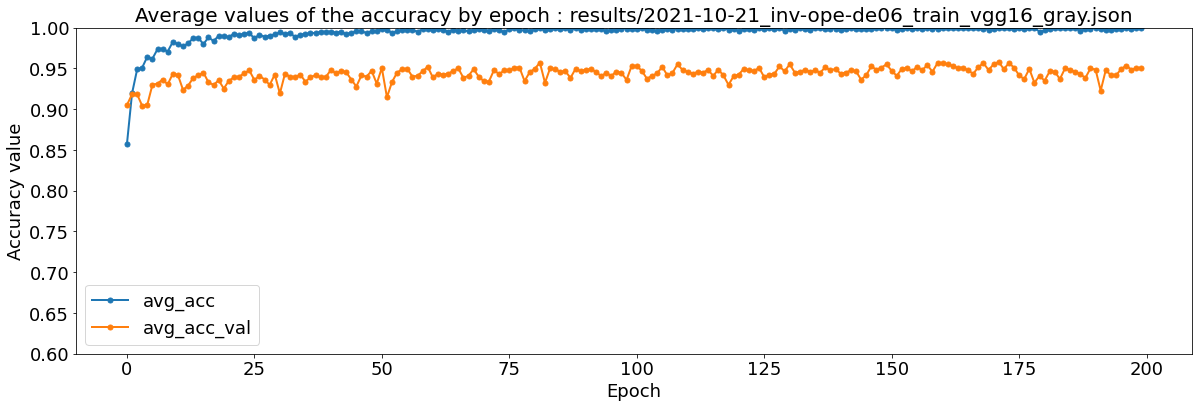

In [15]:
for model_name in args.model_names:
    filename = f'results/{datetag}_{args.HOST}_train_{model_name}.json'
    df_train = pd.read_json(filename)
    fig, axs = plt.subplots(figsize=(fig_width, fig_width/phi//2))
    # plt.xticks(fontsize=18)
    # plt.yticks(fontsize=18)
    ax = df_train['avg_acc'].plot(lw=2, marker='.', markersize=10)
    ax = df_train['avg_acc_val'].plot(lw=2, marker='.', markersize=10)
    ax.legend(["avg_acc", "avg_acc_val"], fontsize=18);
    ax.set_xlabel("Epoch", size=18)
    ax.set_ylabel("Accuracy value", size=18)
    ax.set_ylim(0.60, 1)
    axs.set_title(f'Average values of the accuracy by epoch : {filename}' , size = 20)

In [ ]:
scriptname = 'experiment_scan.py'

In [ ]:
%%writefile {scriptname}

#import model's script and set the output file
from experiment_train import train_model
filename = f'results/{datetag}_train_scan_{args.HOST}.json'
print(f'{filename=}')

measure_columns = ['lr', 'avg_loss_val', 'avg_acc_val', 'time']

def main(N_scan=7, base=10, N_avg=10):
    if os.path.isfile(filename):
        df_scan = pd.read_json(filename)
    else:
        i_trial = 0
        df = pd.DataFrame([], columns=measure_columns) 
        for i_trial, lr  in enumerate(args.lr * np.logspace(-1, 1, N_scan, base=base)):

            # Training and saving the network
            models_vgg_ = torchvision.models.vgg16(pretrained=True)
            # Freeze training for all layers
            # Newly created modules have require_grad=True by default
            for param in models_vgg_.features.parameters():
                param.require_grad = False 

            num_features = models_vgg_.classifier[-1].in_features
            features = list(models_vgg_.classifier.children())[:-1] # Remove last layer
            features.extend([nn.Linear(num_features, n_output)]) # Add our layer with `n_output` outputs
            models_vgg_.classifier = nn.Sequential(*features) # Replace the model classifier

            since = time.time()

            (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(image_size=args.image_size, p=0)
            models_vgg_, df_train = train_model(models_vgg_, num_epochs=args.num_epochs//4, dataloaders=dataloaders)

            df_train.to_json(filename)
            elapsed_time = time.time() - since
            print(f"Training completed in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")

            df_scan.loc[i_trial] = {'lr':lr, 'avg_loss_val':df_train.iloc[-N_avg:-1]['avg_loss_val'].mean(), 
                               'avg_acc_val':df_train.iloc[-N_avg:-1]['avg_acc_val'].mean(), 'time':elapsed_time}
            print(df_scan.loc[i_trial])
            i_trial += 1
        df_scan.to_json(filename)

main()    

In [ ]:
%run -int {scriptname}

In [21]:
df_scan

0.2831148818444445

# Experiment 1: Image processing and recognition for differents labels 


The networks are now ready for a quantitative evaluation. The second part of this notebook offers a comparison between : 

- A pre-trained image recognition's networks, here VGG, trained on the [Imagenet](http://image-net.org/) dataset wich allows to work on naturals images for $1000$ labels, taken from the `torchvision.models` library

- And four re-trained version of the same network VGG16 based on a reduced Imagenet dataset wich allows to focus on naturals images from $10$ labels.

For further statistical analyses, we extract these differents factors (like the accuracy and the processing time for differents datasets at differents resolution) in a `pandas` object. 

In [ ]:
scriptname = 'experiment_basic.py'

In [ ]:
%%writefile {scriptname}

#import model's script and set the output file
from DCNN_transfer_learning.model import *
#from experiment_train import *
filename = f'results/{datetag}_results_1_{args.HOST}.json'
print(f'{filename=}')
def main():
    if os.path.isfile(filename):
        df = pd.read_json(filename)
    else:
        i_trial = 0
        df = pd.DataFrame([], columns=['model', 'perf', 'fps', 'time', 'label', 'i_label', 'i_image', 'filename', 'device_type', 'top_1']) 
        (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(image_size=args.image_size, batch_size=1)
        
        for i_image, (data, label) in enumerate(dataloaders['test']):            
            data, label = data.to(device), label.to(device)
            
            for model_name in models_vgg.keys():
                model = models_vgg[model_name]
                model = model.to(device)

                with torch.no_grad():
                    i_label_top = reverse_labels[image_datasets['test'].classes[label]]
                    tic = time.time()
                    out = model(data).squeeze(0)
                    _, indices = torch.sort(out, descending=True)
                    if model_name == 'vgg' : # our previous work
                        top_1 = labels[indices[0]]
                        percentage = torch.nn.functional.softmax(out[args.subset_i_labels], dim=0) * 100
                        perf_ = percentage[reverse_subset_i_labels[i_label_top]].item()
                    else :
                        top_1 = subset_labels[indices[0]] 
                        percentage = torch.nn.functional.softmax(out, dim=0) * 100
                        perf_ = percentage[label].item()
                    elapsed_time = time.time() - tic
                    
                print(f'The {model_name} model get {labels[i_label_top]} at {perf_:.2f} % confidence in {elapsed_time:.3f} seconds, best confidence for : {top_1}')
                df.loc[i_trial] = {'model':model_name, 'perf':perf_, 'time':elapsed_time, 'fps': 1/elapsed_time,
                                   'label':labels[i_label_top], 'i_label':i_label_top, 
                                   'i_image':i_image, 'filename':image_datasets['test'].imgs[i_image][0], 'device_type':device.type, 'top_1':top_1}
                i_trial += 1
        df.to_json(filename)

main()    

In [ ]:
%run -int {scriptname}

Here we collect our results, we can already display all the data in a table 

In [ ]:
filename = f'results/{datetag}_results_1_{args.HOST}.json'
filename

In [ ]:
df = pd.read_json(filename)
df

## Accuracy, Precision, Recall

We now compute the top-1 accuracy (which is a metric that describes how the model performs across all classes, here top 1 because we only take the best likelihood at the outputof the networks), the precision (which reflects how reliable the model is in classifying samples as Positive) and the recall (which measures the model's ability to detect Positive samples) of each networks. We use the [sklearn librairy](https://sklearn.org/index.html) to perform this [analysis](https://blog.paperspace.com/deep-learning-metrics-precision-recall-accuracy/).

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, f1_score

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html

In [ ]:
df_precision = pd.DataFrame({model_name: {subset_label: precision_score(df[(df['model']==model_name) & (df['label']==subset_label)]["top_1"], 
                                                                  df[(df['model']==model_name) & (df['label']==subset_label)]["label"],
                                                                 average='micro')
                                    for subset_label in subset_labels} 
                       for model_name in models_vgg.keys()})

In [ ]:
ax = df_precision.plot.bar(rot=60, figsize=(fig_width, fig_width//4), fontsize=18)
ax.set_ylim(0, 1)
ax.hlines(xmin=-.5, xmax=len(subset_labels)-.5, y=1/n_output, ls='--', ec='k', label='chance level')
plt.legend(bbox_to_anchor=(1.1, .5), loc='lower right')
ax.set_title('Precision for each models - experiment 1', size=20)
ax.set_ylabel('Accuracy', size=14)
ax.set_xlabel('Models', size=14);

TODO : use the f1-score everywhere
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

In [ ]:
df_f1_score = pd.DataFrame({model_name: {subset_label: f1_score(df[(df['model']==model_name) & (df['label']==subset_label)]["top_1"], 
                                                                df[(df['model']==model_name) & (df['label']==subset_label)]["label"],
                                                                average='micro')
                                    for subset_label in subset_labels} 
                       for model_name in models_vgg.keys()})

ax = df_f1_score.plot.bar(rot=60, figsize=(fig_width, fig_width//4), fontsize=18)
ax.set_ylim(0, 1)
ax.hlines(xmin=-.5, xmax=len(subset_labels)-.5, y=1/n_output, ls='--', ec='k', label='chance level')
plt.legend(bbox_to_anchor=(1.1, .5), loc='lower right')
ax.set_title('F1-score for each models - experiment 1', size=20)
ax.set_ylabel('Accuracy', size=14);

In [ ]:
df_acc = pd.DataFrame({model_name: {subset_label: accuracy_score(df[(df['model']==model_name) & (df['label']==subset_label)]["top_1"], 
                                                                 df[(df['model']==model_name) & (df['label']==subset_label)]["label"])
                                    for subset_label in subset_labels} 
                       for model_name in models_vgg.keys()})

ax = df_acc.plot.bar(rot=60, figsize=(fig_width, fig_width//4), fontsize=18)
ax.set_ylim(0, 1)
ax.hlines(xmin=-.5, xmax=len(subset_labels)-.5, y=1/n_output, ls='--', ec='k', label='chance level')
plt.legend(bbox_to_anchor=(1.1, .5), loc='lower right')
ax.set_title('Accuracy top_1 : for each models - experiment 1', size=20)
ax.set_ylabel('Accuracy', size=14)
ax.set_xlabel('Models', size=14);

In [ ]:
df_acc = pd.DataFrame({'accuracy': [accuracy_score(df[df['model']==model_name]["top_1"], df[df['model']==model_name]["label"]) for model_name in models_vgg.keys()]}, index=models_vgg.keys())
ax = df_acc.plot.bar(rot=0, figsize=(fig_width, fig_width//4), fontsize=18)
ax.set_ylim(0, 1)
ax.hlines(xmin=-.5, xmax=len(models_vgg.keys())-.5, y=1/n_output, ls='--', ec='k', label='chance level')
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html
ax.bar_label(ax.containers[0], padding=-24, color='black', fontsize=14, fmt='%.3f')
plt.legend(bbox_to_anchor=(1.1, .5), loc='lower right')
ax.set_title('Average accuracy top_1 : for each models - experiment 1', size=20)
ax.set_ylabel('Accuracy', size=14)
ax.set_xlabel('Models', size=14);

## Computation time

A display of the differents computation time of each models on the same dataset for the sequence of trials :

In [ ]:
fig, axs = plt.subplots(len(models_vgg.keys()), 1, figsize=(fig_width, fig_width*phi//2), sharex=True, sharey=True)
# plt.xticks(fontsize=18)
# plt.yticks(fontsize=18)
for ax, color, model_name in zip(axs, colors, models_vgg.keys()):
    ax.set_ylabel('Frequency', fontsize=14)
    df[df['model']==model_name]['time'].plot.hist(bins=150, lw=1, label=model_name,ax=ax, color=color, density=True)
    ax.legend(loc='upper left', fontsize=20)
    ax.set_xlim(df['time'].quantile(.01), df['time'].quantile(.99))
axs[-1].set_xlabel('Processing time (s)', size=18)
axs[0].set_title('Processed on : ' + args.HOST + '_' + str(df['device_type'][0]), size = 20);

## Classification likelihood

This graph shows the frequency of the logit of the classification likelihood for our four models and the pyTorch VGG16 model. The classification likelihood represent a predicted likelihood probability of detection for a given label at the output of the network. As most of them are close either to 100 as to 0, we applied a logit function to make the difference between these networks more obvious.

TODO voir si on peut donner la valeur du logit en hartley base 10 https://en.wikipedia.org/wiki/Hartley_(unit) tracer le chance level

In [ ]:
fig, axs = plt.subplots(len(models_vgg.keys()), 1, figsize=(fig_width, fig_width*phi//2), sharex=True, sharey=True)
# plt.xticks(fontsize=18)
# plt.yticks(fontsize=18)
for ax, color, model_name in zip(axs, colors, models_vgg.keys()):
    ax.set_ylabel('Frequency', fontsize=14)
    (logit(df[df['model']==model_name]['perf']/100)/np.log2(10)).plot.hist(bins=np.linspace(0, 5, 150), lw=1, label=model_name, ax=ax, color=color, density=True)
    #df[df['model']==model_name]['perf'].plot.hist(bins=np.linspace(99.95, 100, 150), lw=1, label=model_name, ax=ax, color=color, density=True)
    ax.legend(loc='upper left', fontsize=20)
    ax.set_ylim(0, 5)
    # ax.tick_params(axis='x', labelsize=14)
    # ax.tick_params(axis='y', labelsize=14)
axs[-1].set_xlabel('Classification likelihood (ban)', size=18)
axs[0].set_title('Processed on : ' + args.HOST + '_' + str(df['device_type'][0]), size = 20);

## Image display

Here we display the 64 *worsts* Classification likelihood's, all model combined : 

In [ ]:
N_image_i = 8
N_image_j = 8
fig, axs = plt.subplots(N_image_i, N_image_j, figsize=(fig_width, fig_width))
for i, idx in enumerate(df["perf"].argsort()[:(N_image_i*N_image_j)]):
    ax = axs[i%N_image_i][i//N_image_i]
    ax.imshow(imageio.imread(image_datasets['test'].imgs[df.loc[idx]['i_image']][0]))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(df.loc[idx]['label'] + ' | ' + df.loc[idx]['model'], color='g')
    perf_ = df.loc[idx]['perf']
    ax.set_ylabel(f'P={perf_:2.3f}%', color='g')

## summary

To make it even clearer we extracted a specific mean for each models : 

Mean accuracy

In [ ]:
for model_name in models_vgg.keys():
    mean_acc = (df[df['model']==model_name]["top_1"] == df[df['model']==model_name]["label"]).mean()
    print(f'For the {model_name} model, the mean accuracy = {mean_acc*100:.4f} %' )

Classification likelihood's mean

In [ ]:
for model_name in models_vgg.keys():
    med_perf = np.mean(df[df['model']==model_name]["perf"])
    print(f'For the {model_name} model, the mean clasification likelihood = {med_perf:.4f} %' )

Computation time 's mean

In [ ]:
for model_name in models_vgg.keys():
    med_perf = np.mean(df[df['model']==model_name]["time"])
    print(f'For the {model_name} model, the mean computation time = {med_perf:.5f} s')

Frame per second's mean

In [ ]:
for model_name in models_vgg.keys():
    med_perf = np.mean(df[df['model']==model_name]["fps"])
    print(f'For the {model_name} model, the mean fps = {med_perf:.3f} Hz' )

# Experiment 2: Image processing and recognition for differents resolutions :

Let's now study that same likelihood indicators at different image resolutions.

In [ ]:
scriptname = 'experiment_downsample.py'

In [ ]:
%%writefile {scriptname}
#import model's script and set the output file
from DCNN_transfer_learning.model import *
filename = f'results/{datetag}_results_2_{args.HOST}.json'

def main():
    if os.path.isfile(filename):
        df_downsample = pd.read_json(filename)
    else:
        i_trial = 0
        df_downsample = pd.DataFrame([], columns=['model', 'perf', 'fps', 'time', 'label', 'i_label', 'i_image', 'image_size', 'filename', 'device_type', 'top_1']) 
        # image preprocessing
        for image_size_ in args.image_sizes:
            (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(image_size=image_size_, batch_size=1)
            print(f'Résolution de {image_size_=}')
            # Displays the input image of the model 
            for i_image, (data, label) in enumerate(dataloaders['test']):                
                data, label = data.to(device), label.to(device)

                for model_name in models_vgg.keys():
                    model = models_vgg[model_name]
                    model = model.to(device)

                    with torch.no_grad():
                        i_label_top = reverse_labels[image_datasets['test'].classes[label]]
                        tic = time.time()
                        out = model(data).squeeze(0)
                        _, indices = torch.sort(out, descending=True)
                        if model_name == 'vgg' : # our previous work
                            top_1 = labels[indices[0]]
                            percentage = torch.nn.functional.softmax(out[args.subset_i_labels], dim=0) * 100
                            perf_ = percentage[reverse_subset_i_labels[i_label_top]].item()
                        else :
                            top_1 = subset_labels[indices[0]] 
                            percentage = torch.nn.functional.softmax(out, dim=0) * 100
                            perf_ = percentage[label].item()
                        dt = time.time() - tic
                    print(f'The {model_name} model get {labels[i_label_top]} at {perf_:.2f} % confidence in {dt:.3f} seconds, best confidence for : {top_1}')
                    df_downsample.loc[i_trial] = {'model':model_name, 'perf':perf_, 'time':dt, 'fps': 1/dt,
                                       'label':labels[i_label_top], 'i_label':i_label_top, 
                                       'i_image':i_image, 'filename':image_datasets['test'].imgs[i_image][0], 'image_size': image_size_, 'device_type':device.type, 'top_1':str(top_1)}
                    i_trial += 1

            df_downsample.to_json(filename)

main()            

In [ ]:
%run -int {scriptname}

Here, again, we collect our results, and display all the data in a table 

In [ ]:
filename = f'results/{datetag}_results_2_{args.HOST}.json'
#filename = 'results/2021-04-20_results_2_INV-133-DE01.json'
df_downsample = pd.read_json(filename)
df_downsample

## Accuracy

And extract the accuracy, the precision ans the recall for each networks :

In [ ]:
for image_size in args.image_sizes:
    pprint(f'Benchmarking image size = {image_size}')
    df_acc = pd.DataFrame({model_name: {subset_label: accuracy_score(df_downsample[(df_downsample['model']==model_name) & (df_downsample['image_size']==image_size)]["top_1"], 
                                                                     df_downsample[(df_downsample['model']==model_name) & (df_downsample['image_size']==image_size)]["label"])
                                        for subset_label in subset_labels} 
                           for model_name in models_vgg.keys()})

    ax = df_acc.plot.bar(rot=60, figsize=(fig_width, fig_width//4), fontsize=18)
    ax.set_ylim(0, 1)
    ax.hlines(xmin=-.5, xmax=len(subset_labels)-.5, y=1/n_output, ls='--', ec='k', label='chance level')
    plt.legend(bbox_to_anchor=(1.1, .5), loc='lower right')
    ax.set_title(f'Experiment 2 - image size = {image_size}', size=20)
    ax.set_ylabel('Accuracy top_1', size=14)
    plt.show();


In [ ]:
df_acc = pd.DataFrame({model_name: {image_size: accuracy_score(df_downsample[(df_downsample['model']==model_name) & (df_downsample['image_size']==image_size)]["top_1"], 
                                                               df_downsample[(df_downsample['model']==model_name) & (df_downsample['image_size']==image_size)]["label"])
                                    for image_size in args.image_sizes} 
                       for model_name in models_vgg.keys()})

ax = df_acc.plot.bar(rot=0, figsize=(fig_width, fig_width//4), fontsize=18)
ax.set_ylim(0, 1)
ax.hlines(xmin=-.5, xmax=len(models_vgg.keys())-.5, y=1/n_output, ls='--', ec='k', label='chance level')
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html
for container in ax.containers: ax.bar_label(container, padding=-50, color='black', fontsize=14, fmt='%.3f', rotation=90)
plt.legend(bbox_to_anchor=(1.1, .5), loc='lower right')
ax.set_title(f'Experiment 2 - image sizes = {args.image_sizes}', size=20)
ax.set_ylabel('Accuracy', size=14)
plt.show();

In [ ]:
ax = df_acc.T.plot.bar(rot=0, figsize=(fig_width, fig_width//4), fontsize=18)
ax.set_ylim(0, 1)
ax.hlines(xmin=-.5, xmax=len(models_vgg.keys())-.5, y=1/n_output, ls='--', ec='k', label='chance level')
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html
for container in ax.containers: ax.bar_label(container, padding=-50, color='black', fontsize=14, fmt='%.3f', rotation=90)
plt.legend(bbox_to_anchor=(1.1, .5), loc='lower right')
ax.set_title(f'Experiment 2 - image sizes = {args.image_sizes}', size=20)
ax.set_ylabel('Accuracy', size=14)
plt.show();

## Computation time

A display of the differents computation time of each models on the same dataset for differents resolutions :

In [ ]:
fig, axs = plt.subplots(figsize=(fig_width, fig_width/phi))
# plt.xticks(fontsize=18)
# plt.yticks(fontsize=18)
for color, model_name in zip(colors, models_vgg.keys()):
    axs = sns.violinplot(x="image_size", y="time", data=df_downsample, inner="quartile", hue='model')
    axs.set_title('Processed on : ' + args.HOST + '_' + str(df_downsample['device_type'][0]), size = 20)
    axs.set_ylabel('Computation time (s)', size=18)
    axs.set_xlabel('Trial', size=18)
    axs.set_yscale('log')
h, l = axs.get_legend_handles_labels()
axs.legend(h[:5], l[:5], loc='upper center', fontsize=16);

## Classification likelihood

Let's display the likelihood of each models on the same dataset for differents resolutions. Here accuracies are displayed as a violin plot to allow a better representation of the models.

In [ ]:
fig, axs = plt.subplots(figsize=(fig_width, fig_width/phi))
# plt.xticks(fontsize=18)
# plt.yticks(fontsize=18)
axs = sns.violinplot(x="image_size", y="perf", data=df_downsample, inner="quartile", hue='model', cut = 0, scale = 'width')
axs.set_title('Processed on : ' + args.HOST + '_' + str(df_downsample['device_type'][0]), size=20)
axs.set_ylabel('Classification likelihood (%)', size=18)
axs.set_xlabel('Image size', size=18)
h, l = axs.get_legend_handles_labels()
axs.legend(h[:5], l[:5], loc ='center', fontsize=16);

## Image display

The 64 worsts classification likelihood, all models and sizes combined : 

In [ ]:
N_image_i = 8
N_image_j = 8
fig, axs = plt.subplots(N_image_i, N_image_j, figsize=(fig_width, fig_width))
for i, idx in enumerate(df_downsample["perf"].argsort()[:(N_image_i*N_image_j)]):
    ax = axs[i%N_image_i][i//N_image_i]
    ax.imshow(imageio.imread(image_datasets['test'].imgs[df_downsample.loc[idx]['i_image']][0]))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(df_downsample.loc[idx]['label'] + ' | ' + df_downsample.loc[idx]['model']+ ' | ' + str(df_downsample.loc[idx]['image_size']), color='g')
    perf_ = df_downsample.loc[idx]['perf']
    ax.set_ylabel(f'P={perf_:2.3f}%', color='g')

## summary

Again, we extracted a specific mean for each models : 

Mean accuracy

In [ ]:
for model_name in models_vgg.keys():
    pprint(f'Benchmarking model {model_name}')
    for image_size in args.image_sizes:
        df_ = df_downsample[(df_downsample['model']==model_name) & (df_downsample['image_size']==image_size)]
        mean_acc = (df_["top_1"] == df_["label"]).mean()
        print(f'For size {image_size}, the mean accuracy = {mean_acc*100:.4f} %' )

Classification likelihood's mean

In [ ]:
for model_name in models_vgg.keys():
    pprint(f'Benchmarking model {model_name}')
    for image_size in args.image_sizes:
        med_perf = np.mean(df_downsample[(df_downsample['model']==model_name) & (df_downsample['image_size']==image_size)]["perf"])
        print(f'For size {image_size}, the mean clasification likelihood = {med_perf:.5f} %' )

Computation time 's mean

In [ ]:
for model_name in models_vgg.keys():
    pprint(f'Benchmarking model {model_name}')
    for image_size in args.image_sizes:
        med_perf = np.mean(df_downsample[(df_downsample['model']==model_name) & (df_downsample['image_size']==image_size)]["time"])
        print(f'For size {image_size}, the mean computation time = {med_perf:.3f} s' )

Frame per second's mean

In [ ]:
for model_name in models_vgg.keys():
    pprint(f'Benchmarking model {model_name}')
    for image_size in args.image_sizes:
        med_perf = np.mean(df_downsample[(df_downsample['model']==model_name) & (df_downsample['image_size']==image_size)]["fps"])
        print(f'For size {image_size}, the mean fps = {med_perf:.3f} Hz' )

# Experiment 3: Image processing and recognition on grayscale images :

Again, same likelihood indicators but now with a grayscale transformation.

In [ ]:
scriptname = 'experiment_grayscale.py'

In [ ]:
%%writefile {scriptname}

#import model's script and set the output file
from DCNN_transfer_learning.model import *
filename = f'results/{datetag}_results_3_{args.HOST}.json'

def main():
    if os.path.isfile(filename):
        df_gray = pd.read_json(filename)
    else:
        i_trial = 0
        df_gray = pd.DataFrame([], columns=['model', 'perf', 'fps', 'time', 'label', 'i_label', 'i_image', 'filename', 'device_type', 'top_1']) 
        # image preprocessing setting a grayscale output
        (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(image_size=args.image_size, p=1, batch_size=1)

        # Displays the input image of the model 
        for i_image, (data, label) in enumerate(dataloaders['test']):
            data, label = data.to(device), label.to(device)

            for model_name in models_vgg.keys():
                model = models_vgg[model_name]
                model = model.to(device)

                with torch.no_grad():
                    i_label_top = reverse_labels[image_datasets['test'].classes[label]]
                    tic = time.time()
                    out = model(data).squeeze(0)
                    if model_name == 'vgg' :
                        percentage = torch.nn.functional.softmax(out[args.subset_i_labels], dim=0) * 100
                        _, indices = torch.sort(out, descending=True)
                        top_1 = labels[indices[0]]
                        perf_ = percentage[reverse_subset_i_labels[i_label_top]].item()
                    else :
                        percentage = torch.nn.functional.softmax(out, dim=0) * 100
                        _, indices = torch.sort(out, descending=True)
                        top_1 = subset_labels[indices[0]] 
                        perf_ = percentage[label].item()
                dt = time.time() - tic
                df_gray.loc[i_trial] = {'model':model_name, 'perf':perf_, 'time':dt, 'fps': 1/dt,
                                   'label':labels[i_label_top], 'i_label':i_label_top, 
                                   'i_image':i_image, 'filename':image_datasets['test'].imgs[i_image][0], 'device_type':device.type, 'top_1':str(top_1)}
                print(f'The {model_name} model get {labels[i_label_top]} at {perf_:.2f} % confidence in {dt:.3f} seconds, best confidence for : {top_1}')
                i_trial += 1
        df_gray.to_json(filename)

main()    

In [ ]:
%run -int {scriptname}


Collecting all the results, displaying all the data in a table 

In [ ]:
filename = f'results/{datetag}_results_3_{args.HOST}.json'
#filename = 'results/2021-04-20_results_3_INV-133-DE01.json'
df_gray = pd.read_json(filename)
df_gray

In [ ]:
np.unique(df_gray['model'])

## Image display

The 64 worsts classification likelihood, all model combined : 

In [ ]:
N_image_i = 8
N_image_j = 8

fig, axs = plt.subplots(N_image_i, N_image_j, figsize=(fig_width, fig_width))
for i, idx in enumerate(df_gray["perf"].argsort()[:(N_image_i*N_image_j)]):
    ax = axs[i%N_image_i][i//N_image_i]
    ax.imshow(imageio.imread(image_datasets['test'].imgs[df_gray.loc[idx]['i_image']][0], pilmode="L"), cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(df_gray.loc[idx]['label'] + ' | ' + df_gray.loc[idx]['model'], color='g')
    perf_ = df_gray.loc[idx]['perf']
    ax.set_ylabel(f'P={perf_:2.3f}%', color='g')

### Classification likelihood compared with experiment 1

Let's analyze the classification likelihood of each models on the same dataset for color versus grayscale images. Here likelihood's are displayed as a violin plot to allow a better representation of the models.

In [ ]:
import seaborn as sns

fig, axs = plt.subplots(figsize=(fig_width, fig_width/phi**2))
# plt.xticks(fontsize=18)
# plt.yticks(fontsize=18)
for color, df_, label in zip(['gray', 'red'], [df_gray, df], ['black', 'color']):
    axs = sns.violinplot(x="model", y="perf", data=df_, inner="quartile", cut=0, color=color, alpha=.5, scale = 'width')
axs.set_title('Processed on : ' + args.HOST + '_' + str(df_['device_type'][0]), size=20)
axs.set_ylabel('Classification likelihood (%)', size=18)
axs.set_xlabel('Model', size=18)
axs.legend(['Color', 'Gray'], fontsize=18)
    

Classification likelihood's mean

In [ ]:
for model_name in models_vgg.keys():
    med_perf_orig = np.mean(df[df['model']==model_name]["perf"])
    med_perf = np.mean(df_gray[df_gray['model']==model_name]["perf"])
    print(f'For the {model_name} model, the mean clasification likelihood = {med_perf:.5f} % (color = {med_perf_orig:.5f} % )' )
    print(stats.ttest_1samp(df_gray[df_gray['model']==model_name]["perf"], np.mean(df[df['model']==model_name]["perf"])))

## Accuracy of the learned models on grayscale images

Mean accuracy

In [ ]:
for model_name in models_vgg.keys():
    mean_acc_orig = (df[df['model']==model_name]["top_1"] == df[df['model']==model_name]["label"]).mean()
    mean_acc = (df_gray[df_gray['model']==model_name]["top_1"] == df_gray[df_gray['model']==model_name]["label"]).mean()
    print(f'For the {model_name} model, the mean clasification likelihood = {mean_acc*100:.5f} % (color = {mean_acc_orig*100:.5f} % )' )

In [ ]:
df_acc = pd.DataFrame({model_name: {subset_label: accuracy_score(df[(df['model']==model_name) & (df['label']==subset_label)]["top_1"], 
                                                                 df[(df['model']==model_name) & (df['label']==subset_label)]["label"])
                                    for subset_label in subset_labels} 
                       for model_name in models_vgg.keys()})

ax = df_acc.plot.bar(rot=60, figsize=(fig_width, fig_width//4), fontsize=18)
ax.set_ylim(0, 1)
ax.hlines(xmin=-.5, xmax=len(subset_labels)-.5, y=1/n_output, ls='--', ec='k', label='chance level')
plt.legend(bbox_to_anchor=(1.1, .5), loc='lower right')
ax.set_title('Accuracy top_1 : for each models - experiment 1', size=20)
ax.set_ylabel('Accuracy', size=14)
ax.set_xlabel('Models', size=14);

In [ ]:
df_acc = pd.DataFrame({model_name: {label: accuracy_score(df_[(df_['model']==model_name)]["top_1"], 
                                                               df_[(df_['model']==model_name)]["label"])
                                    for label, df_ in zip(['original', 'gray'], [df, df_gray])} 
                       for model_name in models_vgg.keys()})

ax = df_acc.T.plot.bar(rot=0, figsize=(fig_width, fig_width//4), fontsize=18)
ax.set_ylim(0, 1)
ax.hlines(xmin=-.5, xmax=len(models_vgg.keys())-.5, y=1/n_output, ls='--', ec='k', label='chance level')
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html
for container in ax.containers: ax.bar_label(container, padding=-50, color='black', fontsize=14, fmt='%.3f', rotation=90)
plt.legend(bbox_to_anchor=(1.1, .5), loc='lower right')
ax.set_title(f'Experiment 3 - color vs gray images', size=20)
ax.set_ylabel('Accuracy', size=14)
plt.show();

## Computation time

A display of the differents computation time of each models on the same dataset for a single resolution :

In [ ]:
df_gray['time'].min(), df_gray['time'].max(), df_gray['time'].quantile(.005), len(df_gray[df_gray['model']==model_name]['time'])

Computation time 's mean

In [ ]:
for model_name in models_vgg.keys():
    med_perf_orig = np.mean(df[df['model']==model_name]["time"])
    med_perf = np.mean(df_gray[df_gray['model']==model_name]["time"])
    print(f'For the {model_name} model, the mean computation time = {med_perf:.4f} s (color = {med_perf_orig:.4f} s )' )

Frame per second's mean

In [ ]:
for model_name in models_vgg.keys():
    med_perf_orig = np.mean(df[df['model']==model_name]["fps"])
    med_perf = np.mean(df_gray[df_gray['model']==model_name]["fps"])
    print(f'For the {model_name} model, the mean fps = {med_perf:.3f} Hz (color = {med_perf_orig:.3f} Hz )' )

In [ ]:
fig, axs = plt.subplots(len(models_vgg.keys()), 1, figsize=(fig_width, fig_width*phi//2))
for color, df_, label, legend in zip(['gray', 'red'], [df_gray, df], ['black', 'color'], ['Grayscale', 'Regular']):
    for ax, model_name in zip(axs, models_vgg.keys()):
        ax.set_ylabel('Frequency', fontsize=14) 
        df_[df_['model']==model_name]['time'].plot.hist(bins=150, lw=1, label=str(legend+ ' ' + model_name), ax=ax, color=color, density=True)
        ax.legend(loc='upper right', fontsize=20)
        ax.set_xlim(df_gray['time'].quantile(.01), df_gray['time'].quantile(.99))
axs[-1].set_xlabel('Processing time (s)', size=18)
axs[0].set_title('Processed on : ' + args.HOST + '_' + str(df['device_type'][0]), size = 20);

## Classification likelihood

A display of the classification likelihood of each models on the same dataset for a single resolution :

In [ ]:
fig, axs = plt.subplots(len(models_vgg.keys()), 1, figsize=(fig_width, fig_width*phi//2), sharex=True, sharey=True)
# plt.xticks(fontsize=18)
# plt.yticks(fontsize=18)
for ax, color, model_name in zip(axs, colors, models_vgg.keys()):
    ax.set_ylabel('Frequency', fontsize=14)
    df_gray[df_gray['model']==model_name]['perf'].plot.hist(bins=np.linspace(90, 100, 100), lw=0, alpha=0.3, label=model_name + '_gray', ax=ax, color='k', density=True)
    df[df['model']==model_name]['perf'].plot.hist(bins=np.linspace(90, 100, 100), lw=0, alpha=0.3, label=model_name + '_color', ax=ax, color=color, density=True)
    ax.legend(loc='upper left', fontsize=20)
    ax.set_xlim(90, 100)
    ax.set_ylim(0, 1)
    # ax.tick_params(axis='x', labelsize=14)
    # ax.tick_params(axis='y', labelsize=14)
axs[-1].set_xlabel('Classification likelihood (%)', size=18)
axs[0].set_title('Processed on : ' + args.HOST + '_' + str(df['device_type'][0]), size = 20);

## summary


As a summary, we have shown here that one can implement transfer learning on a subset of images and that it reaches a higher accuracy than a simpler hypothesis. We have also shown that transfer learning could also be used to teach the network to different perturbations of the image, for instance changes in the resolution of in the colorspace. Such framework is thus promising for further applications which aim at modelling higher-order cognitive processes.